<a href="https://colab.research.google.com/github/hadar424/my_final_project/blob/main/my_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
# connect to my drive where the kaggle data is saved
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
train_data_path = "./drive/MyDrive/final_project/data/fruits-360-dataset/fruits-360/Training"
test_data_path = "./drive/MyDrive/final_project/data/fruits-360-dataset/fruits-360/Test"

In [4]:
# 131 classes of fruits in kaggle dataset
batch_size = 131
# define model 1 - no transforms, RGB
model1_transforms = transforms.Compose(
[
    transforms.ToTensor()
])

train_dataset1 = datasets.ImageFolder(root= train_data_path, transform=model1_transforms)
test_dataset1 = datasets.ImageFolder(root= test_data_path, transform=model1_transforms)
train_dataloader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
test_dataloader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
images, labels = next(iter(train_dataloader1)) 
print("images-size:", images.shape)
print("labels-size:", labels.shape)

images-size: torch.Size([131, 3, 100, 100])
labels-size: torch.Size([131])


In [5]:
model1 = models.resnet18(pretrained=False)
model1 = model1.cuda() if device else model1
criterion1 = nn.CrossEntropyLoss()
sgd_optimizer1 = optim.SGD(model1.parameters(), lr=0.005, momentum=0.9)

num_features = model1.fc.in_features
# add a fully-connected layer for classification, specifying the classes and number of features (FC 131).
model1.fc = nn.Linear(num_features, batch_size)
model1.fc = model1.fc.cuda()

In [6]:
def train_model(model,n_epochs, loss_func, optimizer, train_dataloader, d_device):
  train_loss = []
  train_acc = []
  total_step = len(train_dataloader)
  for epoch in range(1, n_epochs+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total=0
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
      data_, target_ = data_.to(d_device), target_.to(d_device)
      optimizer.zero_grad()
      outputs = model(data_)
      loss = loss_func(outputs, target_)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      _,pred = torch.max(outputs, dim=1)
      correct += torch.sum(pred==target_).item()
      total += target_.size(0)
      if (batch_idx) % 100 == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
        .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}\n')
    model.eval()
  return train_acc, train_loss

In [7]:
def test_model(model,test_dataloader, d_device):
  total_t=0
  correct_t=0
  with torch.no_grad():
    for data_t, target_t in (test_dataloader):
      data_t, target_t = data_t.to(d_device), target_t.to(d_device)
      outputs_t = model(data_t)
      _,pred_t = torch.max(outputs_t, dim=1)
      correct_t += torch.sum(pred_t==target_t).item()
      total_t += target_t.size(0)
  print(f'test accuracy: {(100 * correct_t/total_t):.4f}')

In [8]:
epoches = 10
# train model 1
train_acc1,train_loss1= train_model(model1,epoches,criterion1,sgd_optimizer1,train_dataloader1,device)

Epoch [1/10], Step [0/201], Loss: 5.0982
Epoch [1/10], Step [100/201], Loss: 3.1745
Epoch [1/10], Step [200/201], Loss: 4.9402

train-loss: 3.1764, train-acc: 49.5878

Epoch [2/10], Step [0/201], Loss: 1.6193
Epoch [2/10], Step [100/201], Loss: 0.8678
Epoch [2/10], Step [200/201], Loss: 4.1442

train-loss: 2.0703, train-acc: 93.1952

Epoch [3/10], Step [0/201], Loss: 0.4416
Epoch [3/10], Step [100/201], Loss: 0.3508
Epoch [3/10], Step [200/201], Loss: 3.4206

train-loss: 1.5036, train-acc: 98.2597

Epoch [4/10], Step [0/201], Loss: 0.2010
Epoch [4/10], Step [100/201], Loss: 0.1458
Epoch [4/10], Step [200/201], Loss: 4.1516

train-loss: 1.1786, train-acc: 99.3207

Epoch [5/10], Step [0/201], Loss: 0.1171
Epoch [5/10], Step [100/201], Loss: 0.1185
Epoch [5/10], Step [200/201], Loss: 3.0792

train-loss: 0.9691, train-acc: 99.6794

Epoch [6/10], Step [0/201], Loss: 0.0788
Epoch [6/10], Step [100/201], Loss: 0.0806
Epoch [6/10], Step [200/201], Loss: 3.9509

train-loss: 0.8251, train-acc: 9

In [9]:
test_model(model1,test_dataloader1,device)

test accuracy: 96.7176


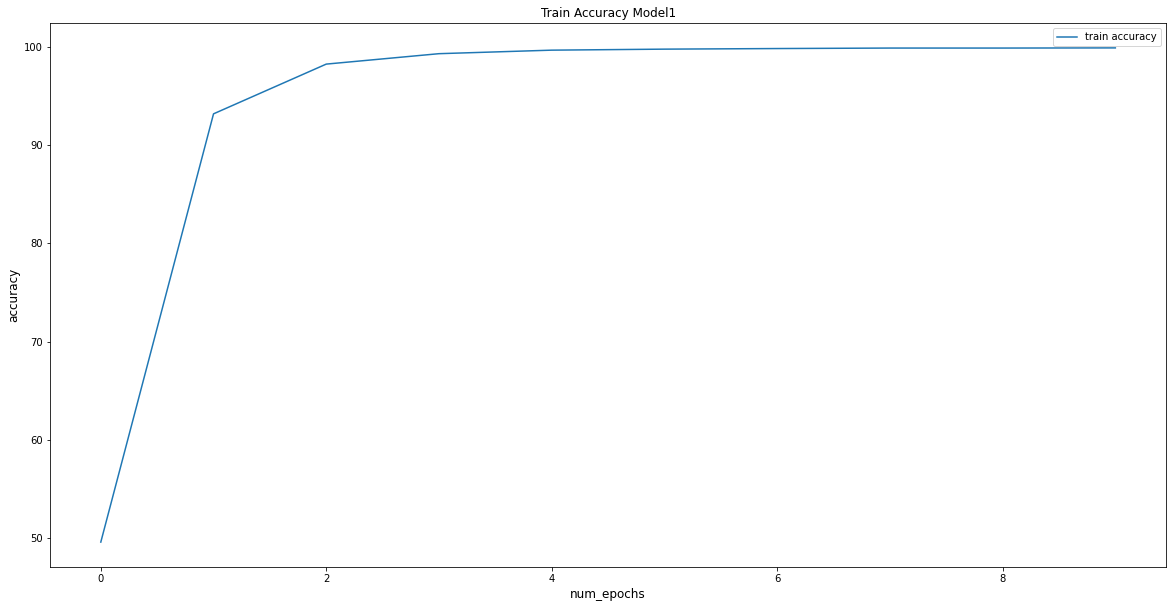

In [10]:
fig = plt.figure(figsize=(20,10))
plt.title("Train Accuracy Model1")
plt.plot(train_acc1, label='train accuracy')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

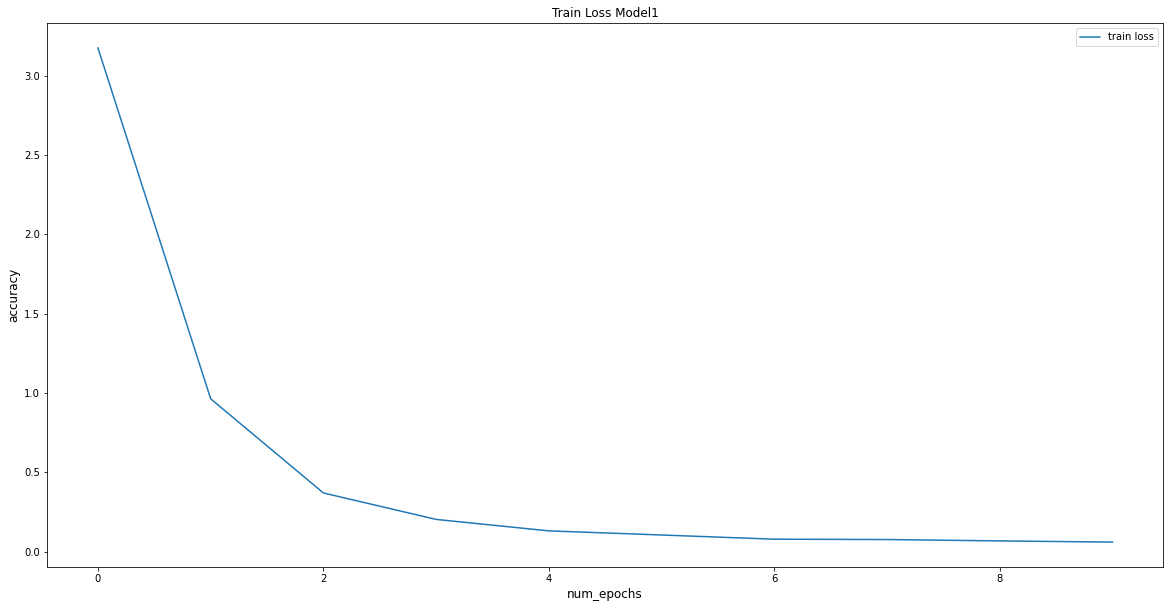

In [11]:
fig = plt.figure(figsize=(20,10))
plt.title("Train Loss Model1")
plt.plot(train_loss1, label='train loss')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [12]:
def visualize_model(model_num, model, num_images, test_dataloader, test_dataset):
    images_so_far = 0
    fig = plt.figure(figsize=(8, 6.5))
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu()
        preds = preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('model {} predicted: {}{} true-label: {}'.format(model_num,test_dataset.classes[preds[j]],'\n', test_dataset.classes[labels[j]]))
            inputs = inputs.cpu()
            image = inputs[j].squeeze().permute(1,2,0)
            plt.imshow(image)
            
            if images_so_far == num_images:
                return 

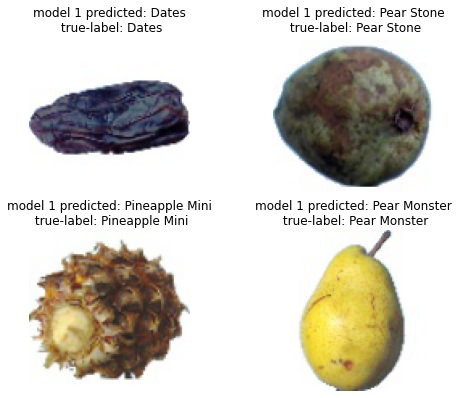

In [13]:
plt.ion()
visualize_model(1, model1, 4, test_dataloader1, test_dataset1)
plt.ioff()
# predictions of model 1

In [14]:
# define model 2 - Gray-Scale
model2_transforms = transforms.Compose(
[
    transforms.ToTensor(),
    transforms.Grayscale(3),
])

train_dataset2 = datasets.ImageFolder(root= train_data_path, transform=model2_transforms)
test_dataset2 = datasets.ImageFolder(root= test_data_path, transform=model2_transforms)
train_dataloader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
test_dataloader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=True)

model2 = models.resnet18(pretrained=False)
model2 = model2.cuda() if device else model2

criterion2 = nn.CrossEntropyLoss()
sgd_optimizer2 = optim.SGD(model2.parameters(), lr=0.005, momentum=0.9)

num_features = model2.fc.in_features
model2.fc = nn.Linear(num_features, batch_size)
model2.fc = model2.fc.cuda()

In [15]:
# train model 2
train_acc2,train_loss2= train_model(model2,epoches,criterion2,sgd_optimizer2,train_dataloader2,device)

Epoch [1/10], Step [0/201], Loss: 5.0478
Epoch [1/10], Step [100/201], Loss: 3.3644
Epoch [1/10], Step [200/201], Loss: 3.8851

train-loss: 3.5003, train-acc: 38.3673

Epoch [2/10], Step [0/201], Loss: 2.3377
Epoch [2/10], Step [100/201], Loss: 1.4693
Epoch [2/10], Step [200/201], Loss: 3.6162

train-loss: 2.5025, train-acc: 84.7531

Epoch [3/10], Step [0/201], Loss: 0.7482
Epoch [3/10], Step [100/201], Loss: 0.5684
Epoch [3/10], Step [200/201], Loss: 3.1725

train-loss: 1.8933, train-acc: 94.9546

Epoch [4/10], Step [0/201], Loss: 0.3924
Epoch [4/10], Step [100/201], Loss: 0.3163
Epoch [4/10], Step [200/201], Loss: 4.1131

train-loss: 1.5106, train-acc: 97.9162

Epoch [5/10], Step [0/201], Loss: 0.2308
Epoch [5/10], Step [100/201], Loss: 0.1716
Epoch [5/10], Step [200/201], Loss: 3.3723

train-loss: 1.2545, train-acc: 99.0650

Epoch [6/10], Step [0/201], Loss: 0.1399
Epoch [6/10], Step [100/201], Loss: 0.1331
Epoch [6/10], Step [200/201], Loss: 3.2316

train-loss: 1.0722, train-acc: 9

In [16]:
test_model(model2,test_dataloader2,device)

test accuracy: 89.8346


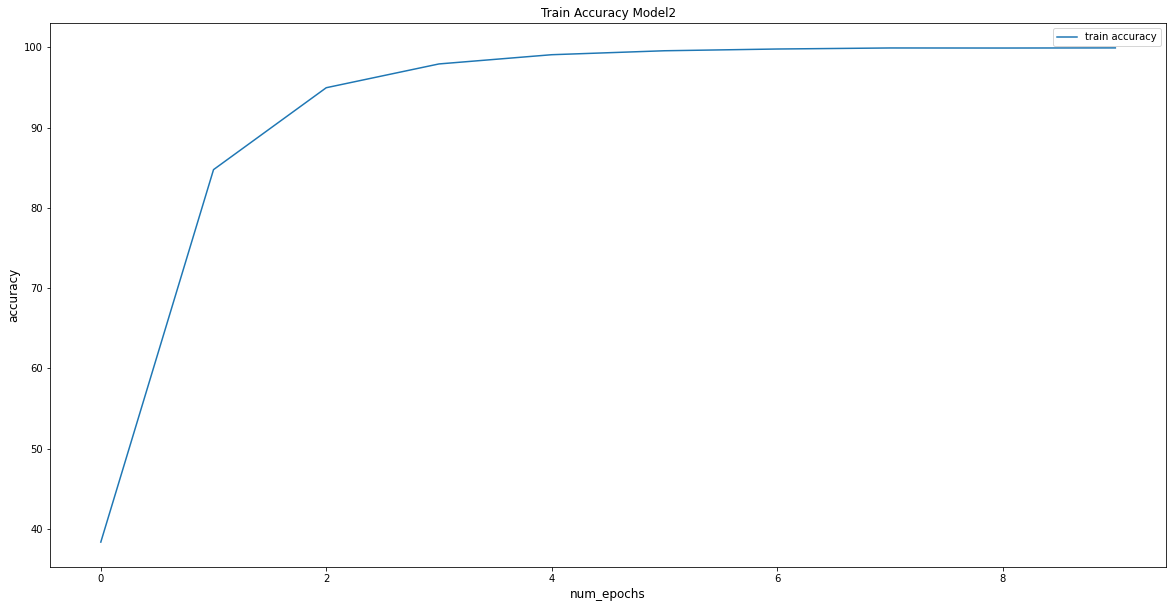

In [17]:
fig = plt.figure(figsize=(20,10))
plt.title("Train Accuracy Model2")
plt.plot(train_acc2, label='train accuracy')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

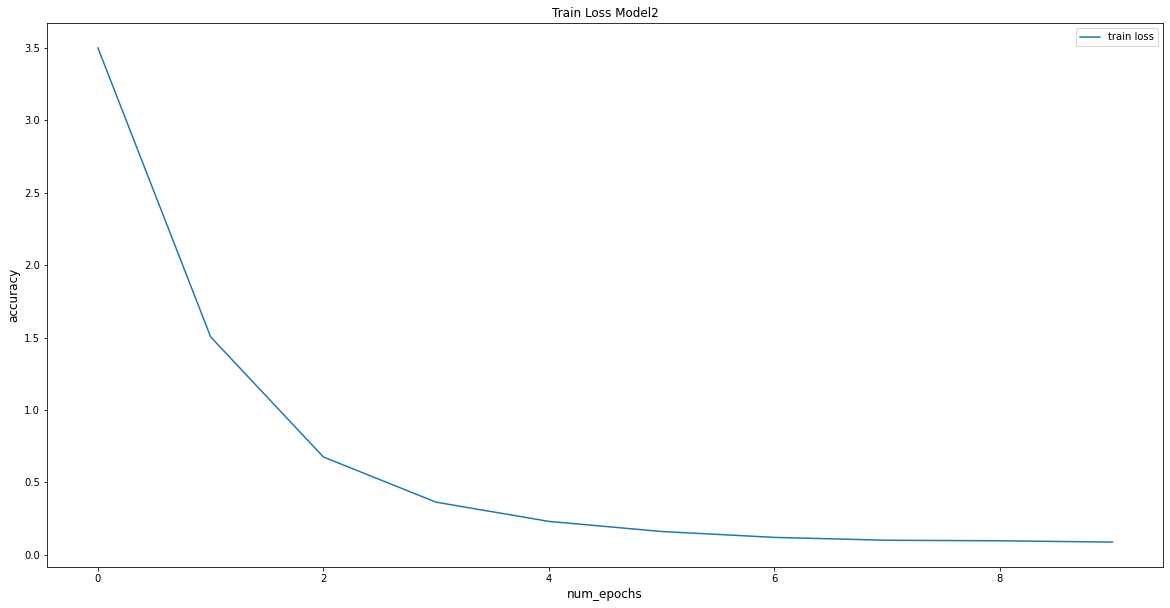

In [18]:
fig = plt.figure(figsize=(20,10))
plt.title("Train Loss Model2")
plt.plot(train_loss2, label='train loss')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

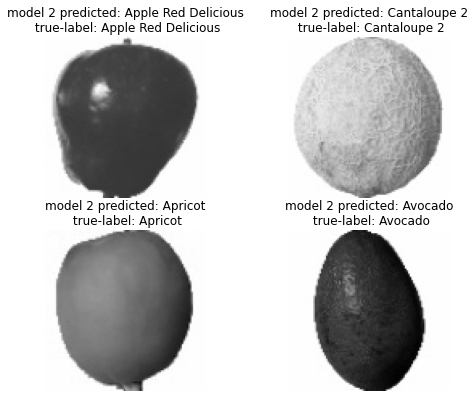

In [19]:
plt.ion()
visualize_model(2, model2, 4, test_dataloader2, test_dataset2)
plt.ioff()
# predictions of model 2

In [20]:
# define model 3 - Gaussian-Blur
model3_transforms = transforms.Compose(
[
    transforms.ToTensor(),
    transforms.GaussianBlur(5,(3,3)),
])

train_dataset3 = datasets.ImageFolder(root= train_data_path, transform=model3_transforms)
test_dataset3 = datasets.ImageFolder(root= test_data_path, transform=model3_transforms)
train_dataloader3 = DataLoader(train_dataset3, batch_size=batch_size, shuffle=True)
test_dataloader3 = DataLoader(test_dataset3, batch_size=batch_size, shuffle=True)

model3 = models.resnet18(pretrained=False)
model3 = model3.cuda() if device else model3

criterion3 = nn.CrossEntropyLoss()
sgd_optimizer3 = optim.SGD(model3.parameters(), lr=0.005, momentum=0.9)

num_features = model3.fc.in_features
model3.fc = nn.Linear(num_features, batch_size)
model3.fc = model3.fc.cuda()

In [21]:
# train model 3
train_acc3,train_loss3 = train_model(model3,epoches,criterion3,sgd_optimizer3,train_dataloader3,device)

Epoch [1/10], Step [0/201], Loss: 5.0421
Epoch [1/10], Step [100/201], Loss: 2.8521
Epoch [1/10], Step [200/201], Loss: 4.6134

train-loss: 3.0353, train-acc: 52.0227

Epoch [2/10], Step [0/201], Loss: 1.6278
Epoch [2/10], Step [100/201], Loss: 0.7822
Epoch [2/10], Step [200/201], Loss: 3.7927

train-loss: 1.9777, train-acc: 93.1265

Epoch [3/10], Step [0/201], Loss: 0.4318
Epoch [3/10], Step [100/201], Loss: 0.2784
Epoch [3/10], Step [200/201], Loss: 3.7514

train-loss: 1.4366, train-acc: 98.2101

Epoch [4/10], Step [0/201], Loss: 0.3004
Epoch [4/10], Step [100/201], Loss: 0.1439
Epoch [4/10], Step [200/201], Loss: 3.1127

train-loss: 1.1248, train-acc: 99.4352

Epoch [5/10], Step [0/201], Loss: 0.1311
Epoch [5/10], Step [100/201], Loss: 0.0960
Epoch [5/10], Step [200/201], Loss: 3.3994

train-loss: 0.9269, train-acc: 99.5878

Epoch [6/10], Step [0/201], Loss: 0.0975
Epoch [6/10], Step [100/201], Loss: 0.0618
Epoch [6/10], Step [200/201], Loss: 3.7342

train-loss: 0.7902, train-acc: 9

In [22]:
test_model(model3,test_dataloader3,device)

test accuracy: 95.8906


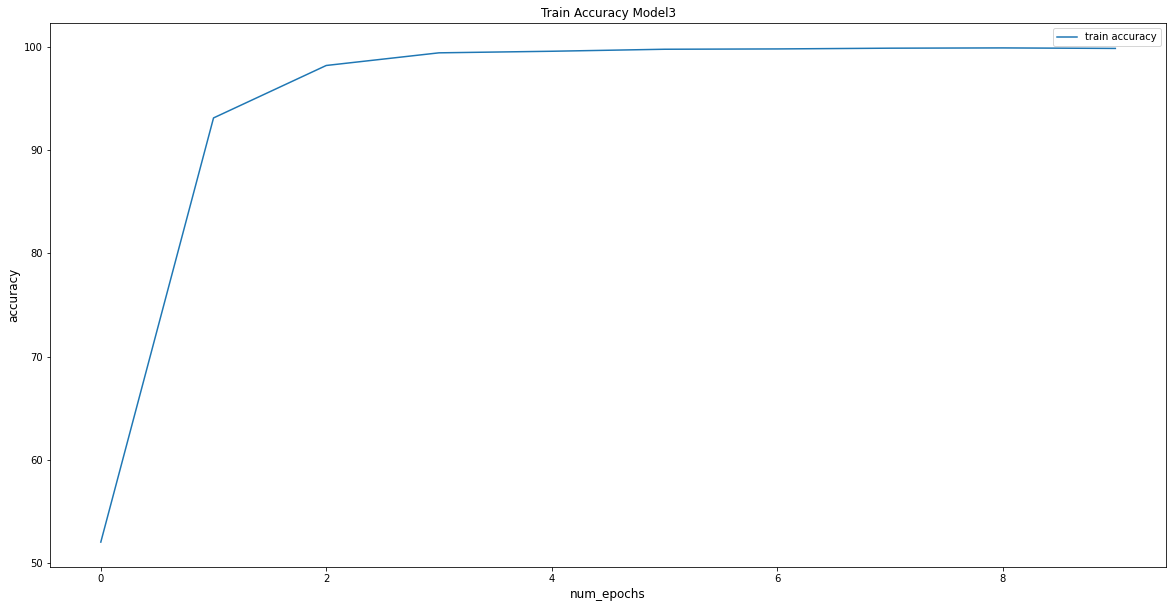

In [23]:
fig = plt.figure(figsize=(20,10))
plt.title("Train Accuracy Model3")
plt.plot(train_acc3, label='train accuracy')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

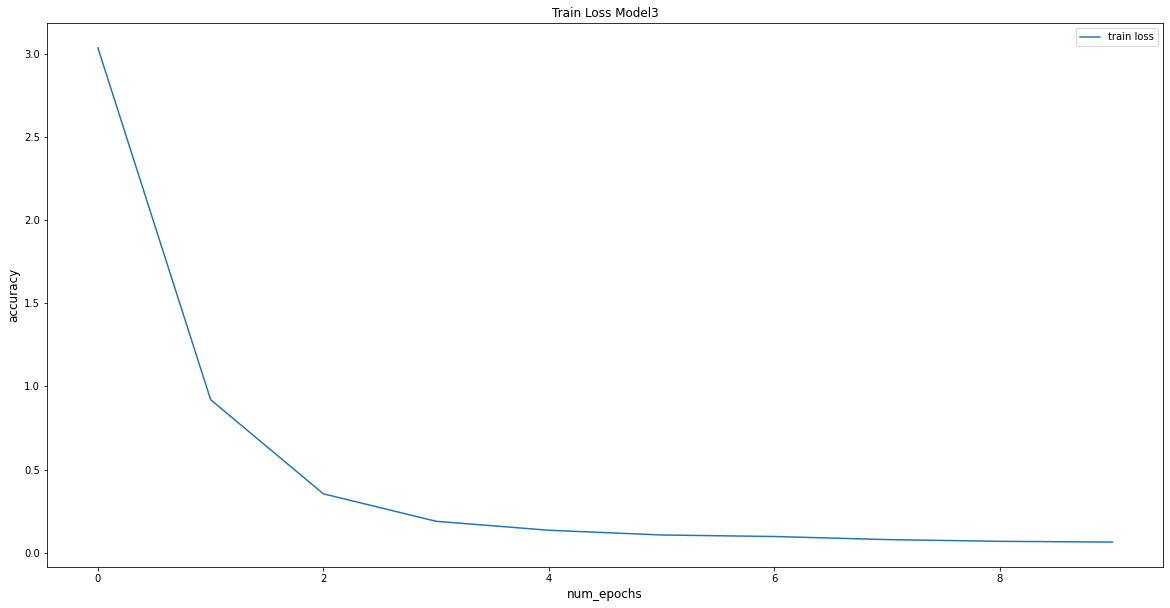

In [24]:
fig = plt.figure(figsize=(20,10))
plt.title("Train Loss Model3")
plt.plot(train_loss3, label='train loss')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

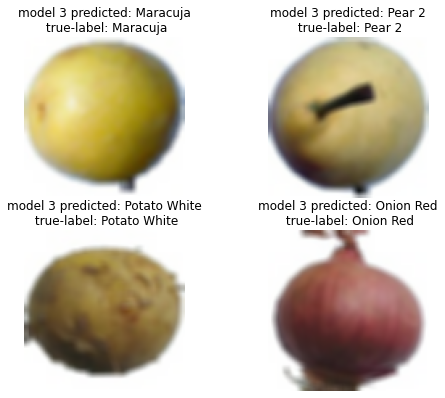

In [25]:
plt.ion()
visualize_model(3, model3, 4, test_dataloader3, test_dataset3)
plt.ioff()
# predictions of model 3

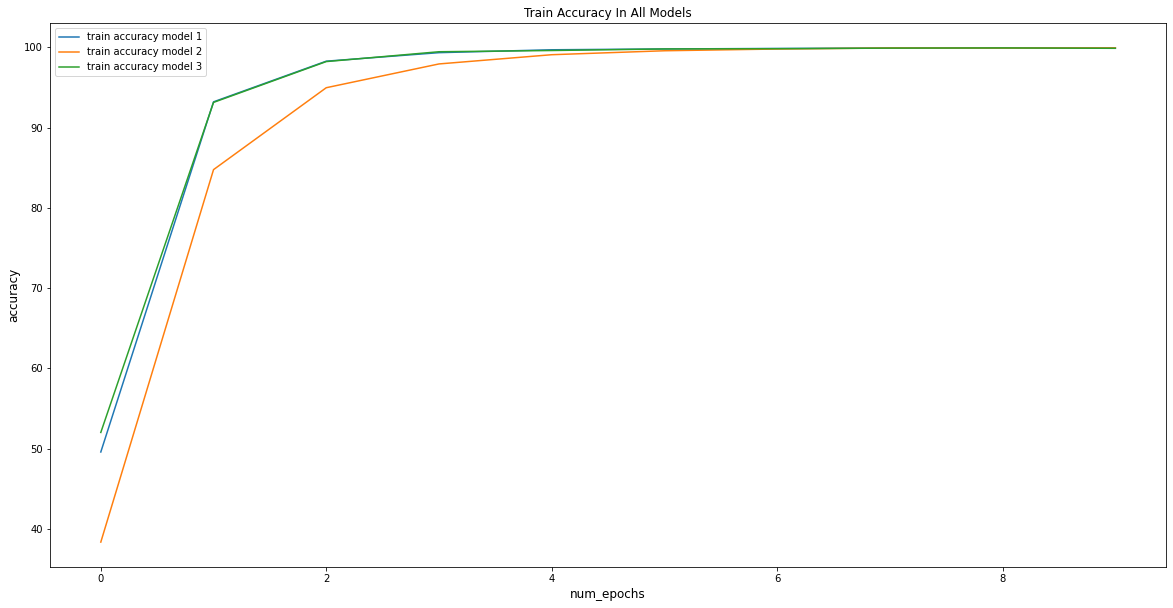

In [26]:
fig = plt.figure(figsize=(20,10))
plt.title("Train Accuracy In All Models")
plt.plot(train_acc1, label='train accuracy model 1')
plt.plot(train_acc2, label='train accuracy model 2')
plt.plot(train_acc3, label='train accuracy model 3')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
# compare the train accuracy in all models

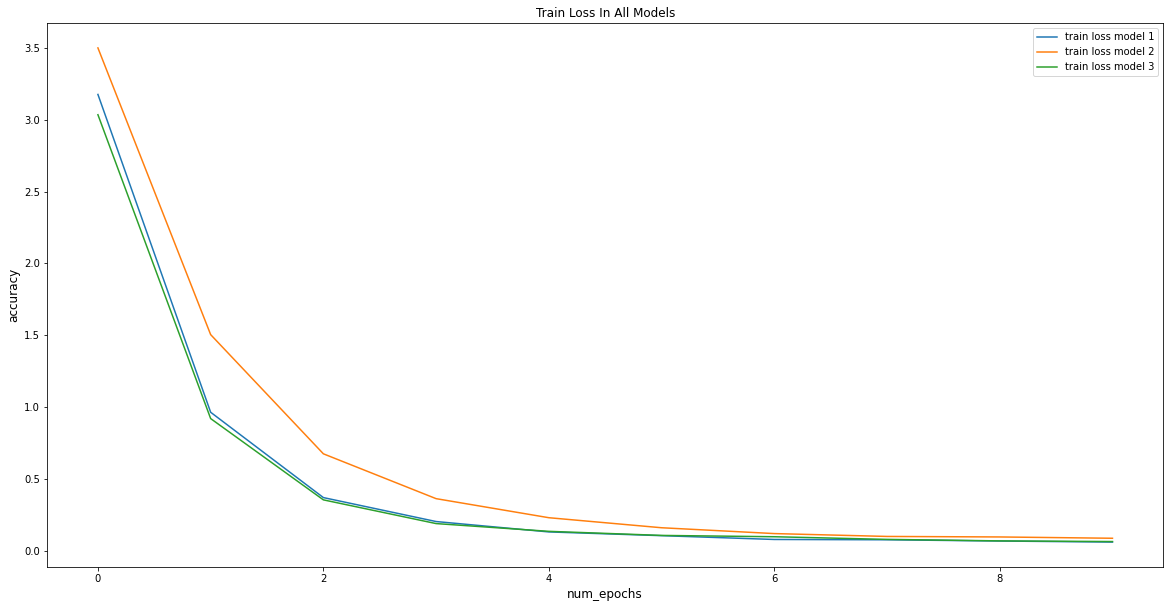

In [27]:
fig = plt.figure(figsize=(20,10))
plt.title("Train Loss In All Models")
plt.plot(train_loss1, label='train loss model 1')
plt.plot(train_loss2, label='train loss model 2')
plt.plot(train_loss3, label='train loss model 3')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
# compare the train loss in all models